1. 赛题目标：通过地标建筑物识别入门语义分割的解题流程和模型
2. 数据说明：图片是航拍图jpg，数据标签是图像像素类别(无建筑和有建筑）RLE编码字符串。


赛题为语义分割任务，因此具体的标签为图像像素类别。在赛题数据中像素属于2类（无建筑物和有建筑物），因此标签为有建筑物的像素。赛题原始图片为jpg格式，标签为RLE编码的字符串。

RLE全称（run-length encoding），翻译为游程编码或行程长度编码，对连续的黑、白像素数以不同的码字进行编码。RLE是一种简单的非破坏性资料压缩法，经常用在在语义分割比赛中对标签进行编码。

RLE与图片之间的转换如下：



In [3]:
import numpy as np
import pandas as pd
import cv2

# 将图片编码为rle格式
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 将rle格式进行解码为图片
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

赛题使用Dice coefficient来衡量选手结果与真实标签的差异性，Dice coefficient可以按像素差异性来比较结果的差异性。Dice coefficient的具体计算方式如下：

$$ \frac{2 * |X \cap Y|}{|X| + |Y|} $$

Baseline: 

In [4]:
# import module

import numba, cv2, gc
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D
import torchvision
from torchvision import transforms as T
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import albumentations as A



In [5]:

class TianChiDataset(D.Dataset):
    def __init__(self, paths, rles, transform, test_mode=False):
        self.paths = paths
        self.rles = rles
        self.transform = transform
        self.test_mode = test_mode

        self.len = len(paths)
        self.as_tensor = T.Compose([
            T.ToPILImage(),
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize([0.625, 0.448, 0.688],
                        [0.131, 0.177, 0.101]),
        ])

    # get data operation
    def __getitem__(self, index):
        img = cv2.imread(self.paths[index])
        if not self.test_mode:
            mask = rle_decode(self.rles[index])
            augments = self.transform(image=img, mask=mask)
            return self.as_tensor(augments['image']), augments['mask'][None]
        else:
            return self.as_tensor(img), ''

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len


class SoftDiceLoss(nn.Module):
    def __init__(self, smooth=1., dims=(-2, -1)):
        super(SoftDiceLoss, self).__init__()
        self.smooth = smooth
        self.dims = dims

    def forward(self, x, y):
        tp = (x * y).sum(self.dims)
        fp = (x * (1 - y)).sum(self.dims)
        fn = ((1 - x) * y).sum(self.dims)

        dc = (2 * tp + self.smooth) / (2 * tp + fp + fn + self.smooth)
        dc = dc.mean()
        return 1 - dc


In [6]:

def get_model():
    model = torchvision.models.segmentation.fcn_resnet50(False)
    pth = torch.load('./weights/fcn_resnet50_coco-1167a1af.pth')
    for key in ["aux_classifier.0.weight", "aux_classifier.1.weight", "aux_classifier.1.bias", "aux_classifier.1.running_mean", "aux_classifier.1.running_var", "aux_classifier.1.num_batches_tracked", "aux_classifier.4.weight", "aux_classifier.4.bias"]:
        del pth[key]
    model.load_state_dict(pth)
    #model = torchvision.models.segmentation.deeplabv3_resnet101(True)
    #model = torchvision.models.segmentation
    model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
    print(model.eval())
    return model


@torch.no_grad()
def validation(model, loader, loss_fn):
    losses = []
    model.eval()
    for image, target in loader:
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        output = model(image)['out']
        loss = loss_fn(output, target)
        losses.append(loss.item())
    return np.array(losses).mean()


def loss_fn(y_pred, y_true):
    bce = bce_fn(y_pred, y_true)
    dice = dice_fn(y_pred.sigmoid(), y_true)
    return 0.8*bce+ 0.2*dice


True


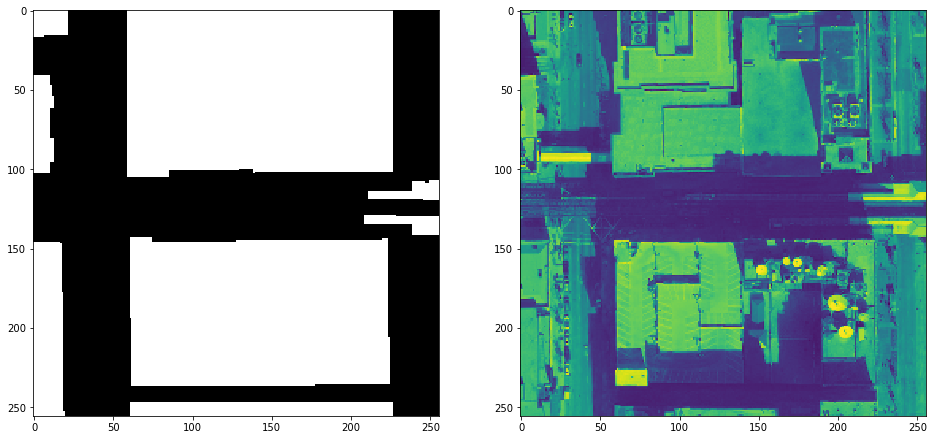

In [7]:
EPOCHES = 20
BATCH_SIZE = 4
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

trfm = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(),
])


train_mask = pd.read_csv('train_mask.csv', sep='\t', names=['name', 'mask'])
train_mask['name'] = train_mask['name'].apply(lambda x: './train/' + x)

img = cv2.imread(train_mask['name'].iloc[0])
mask = rle_decode(train_mask['mask'].iloc[0])

print(rle_encode(mask) == train_mask['mask'].iloc[0])


dataset = TianChiDataset(
    train_mask['name'].values,
    train_mask['mask'].fillna('').values,
    trfm, False
)


image, mask = dataset[0]
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(mask[0], cmap='gray')
plt.subplot(122)
plt.imshow(image[0])
plt.show()


In [6]:

valid_idx, train_idx = [], []
for i in range(len(dataset)):
    if i % 700 == 0:
        valid_idx.append(i)
    #     else:
    elif i % 700 == 1:
        train_idx.append(i)

train_ds = D.Subset(dataset, train_idx)
valid_ds = D.Subset(dataset, valid_idx)

# define training and validation data loaders
loader = D.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

vloader = D.DataLoader(
    valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


model = get_model()
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.to(DEVICE)

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [7]:
import time
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=1e-4, weight_decay=1e-3)

bce_fn = nn.BCEWithLogitsLoss()
dice_fn = SoftDiceLoss()

header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}' * 2 + '\u2502{:6.2f}'
print(header)

EPOCHES = 2
best_loss = 10
for epoch in range(1, EPOCHES + 1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in tqdm_notebook(loader):
        image, target = image.to(DEVICE), target.float().to(DEVICE)
        optimizer.zero_grad()
        output = model(image)['out']
        print("Outside: input size", image.size(),
              "output_size", output.size())
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        # print(loss.item())

    vloss = validation(model, vloader, loss_fn)
    print(raw_line.format(epoch, np.array(losses).mean(), vloss,
                          (time.time() - start_time) / 60 ** 1))
    losses = []

    if vloss < best_loss:
        best_loss = vloss
        torch.save(model.state_dict(), 'model_best.pth')


trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])



subm = []


model.load_state_dict(torch.load("./model_best.pth"))
model.eval()


        Train | Valid
Epoch |  Loss |  Loss | Time, m



Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([3, 3, 256, 256]) output_size torch.Size([3, 1, 256, 256])

     1│  

Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([4, 3, 256, 256]) output_size torch.Size([4, 1, 256, 256])
Outside: input size torch.Size([3, 3, 256, 256]) output_size torch.Size([3, 1, 256, 256])

     2│  

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:

test_mask = pd.read_csv('test_a_samplesubmit.csv', sep='\t', names=['name', 'mask'])
test_mask['name'] = test_mask['name'].apply(lambda x: './test/' + x)
num = len(tqdm_notebook(test_mask['name'].iloc[:]))

for idx, name in enumerate(tqdm_notebook(test_mask['name'].iloc[:])):
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))
    
    if idx % 100 ==0:
        print('Testing Image: {:.1f}'.format(idx*100/num))

        # break
    subm.append([name.split('/')[-1], rle_encode(score_sigmoid)])

subm.to_csv('./tmp.csv', index=None, header=None, sep='\t')


Testing Image: 0.0
Testing Image: 4.0


统计所有图片整图中没有任何建筑物像素占所有训练集图片的比例
统计所有图片中建筑物像素占所有相似度的比例
统计所有图片中建筑物区域平均区域大小

统计所有图片整图中没有任何建筑物像素占所有训练集图片的比例>>>
1%为没有任何建筑物阈值>>>0.076
5%为没有任何建筑物阈值>>>0.201
10%为没有任何建筑物阈值>>>0.293
统计所有图片中建筑物像素占比比例>>> count    24796.000000
mean         0.190048
std          0.156983
min          0.000004
25%          0.052964
50%          0.164669
75%          0.285008
max          0.999222
Name: mask_01, dtype: float64
统计所有图片中建筑物区域平均区域大小>>> 49820.06823681239 0.19004847807621914


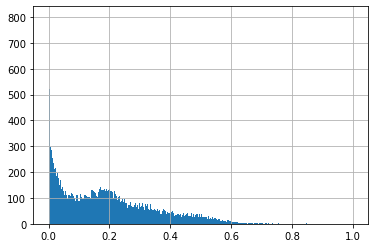

In [8]:
def rle_mask_stats(x):
    if x is np.nan:
        return (None,None,None)
    mask = rle_decode(x) 
    return (mask.sum()/(mask.shape[0]*mask.shape[1]), mask.sum(),mask.shape[0]*mask.shape[1])

train_mask[['mask_01','mask_02','mask_03']] = train_mask['mask'].apply(rle_mask_stats).apply(pd.Series)
train_mask['mask_01'].hist(bins=500)

print('统计所有图片整图中没有任何建筑物像素占所有训练集图片的比例>>>')
print('1%%为没有任何建筑物阈值>>>%.3f'%train_mask['mask_01'].le(0.01).mean())
print('5%%为没有任何建筑物阈值>>>%.3f'%train_mask['mask_01'].le(0.05).mean())
print('10%%为没有任何建筑物阈值>>>%.3f'%train_mask['mask_01'].le(0.1).mean())

print('统计所有图片中建筑物像素占比比例>>>',train_mask['mask_01'].describe())
print('统计所有图片中建筑物区域平均区域大小>>>',train_mask['mask_02'].mean(),train_mask['mask_01'].mean())
